## Redes Neurais Artificiais 2025.2

- **Disciplina**: Redes Neurais Artificiais 2025.2
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta segunda parte do Projeto Prático 2.2 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Testando Redes Neurais sem os Atributos Categórios

1. Abra a base de dados em questão
2. Elimine todas as colunas relativas aos atributos categóricos
3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X
4. Efetue uma partição holdout 70/30 com o sklearn, distribuindo os exemplos de maneira aleatória
5. Efetue o escalonamento dos atributos

### Escalonando os atributos

O treinamento de uma rede neural artificial é mais eficiente quando os valores que lhes são fornecidos como entrada são pequenos, pois isto favorece a convergência. Isto é feito escalonando-se todos os atributos para o intervalo [0,1], mas precisa ser feito de maneira cautelosa, para que informações do conjunto de teste não sejam fornecidas no treinamento.

Há duas estratégias para tal escalonamento: normalização e padronização. Ambas possuem características particulares, vantagens e limitações, como é possível ver aqui: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/


No nosso caso, vamos usar a padronização. Assim, com os atributos preditores do treinamento, isto é, X_train, deve-se subtrair a média e dividir pelo desvio padrão. Para tanto, use o StandardScaler e inicialize-o com os dados do conjunto de treino (fit), ajudando-os em seguida (transform). Depois, ajuste os dados do conjunto de testes.

Se todo o conjunto X for utilizado na padronização, a rede neural receberá informações do conjunto de teste por meio da média e variância utilizada para preparar os dados de treinamento, o que não é desejável.


### Continuando

5. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios  
    5.1 Utilize a função de ativação ReLU  
    5.2 Utilize o solver Adam    
    5.3 Imprima o passo a passo do treinamento    
    5.4 Utilize o número máximo de épocas igual a 300  
6. Com o modelo em questão, após o treinamento, apresente:  
    6.1 Matriz de confusão para o conjunto de teste  
    6.2 Acurácia  
    6.3 F-Score  
    6.4 Precisão  
    6.5 Revocação  
7. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 10 vezes  
    7.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
    7.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
8. Repita por 10 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  
    8.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
9. Houve influência da escolha do otimizador no desempenho da rede?

In [4]:
# === SETUP INICIAL PARA OTIMIZAR O TREINAMENTO ===
import os
import psutil

# Mostra informações úteis
print("Número de CPUs disponíveis:", psutil.cpu_count(logical=True))

# Ativa uso total de núcleos (CPU paralela)
os.environ["OMP_NUM_THREADS"] = str(psutil.cpu_count(logical=True))
os.environ["MKL_NUM_THREADS"] = str(psutil.cpu_count(logical=True))

Número de CPUs disponíveis: 8


In [5]:
import pandas as pd
import numpy as np
import kagglehub

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import random
import pickle
import time

In [6]:
path = kagglehub.dataset_download("uciml/forest-cover-type-dataset")

df = pd.read_csv(path + "/covtype.csv")
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
# Removendo colunas categóricas
categorical_columns = df.columns[df.columns.str.contains("Soil") | df.columns.str.contains("Area")]
display(categorical_columns)
df_novo = df.drop(categorical_columns, axis=1)
df_novo.head()

Index(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,5
1,2590,56,2,212,-6,390,220,235,151,6225,5
2,2804,139,9,268,65,3180,234,238,135,6121,2
3,2785,155,18,242,118,3090,238,238,122,6211,2
4,2595,45,2,153,-1,391,220,234,150,6172,5


In [5]:
# Separando preditores (X) e variável-alvo (y)
X = df_novo.drop(columns=["Cover_Type"])
y = df_novo["Cover_Type"]

In [6]:
# Partição holdout 70/30 do conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

In [8]:
# Escalonamento dos atributos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [9]:
mlp = MLPClassifier((10,), activation="relu", solver="adam", verbose=True, max_iter=300)
mlp.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.96752649
Iteration 2, loss = 0.71692068
Iteration 3, loss = 0.69080085
Iteration 4, loss = 0.68260725
Iteration 5, loss = 0.67850652
Iteration 6, loss = 0.67571961
Iteration 7, loss = 0.67344946
Iteration 8, loss = 0.67159227
Iteration 9, loss = 0.67007673
Iteration 10, loss = 0.66890784
Iteration 11, loss = 0.66794383
Iteration 12, loss = 0.66711762
Iteration 13, loss = 0.66646477
Iteration 14, loss = 0.66576105
Iteration 15, loss = 0.66534265
Iteration 16, loss = 0.66488391
Iteration 17, loss = 0.66444296
Iteration 18, loss = 0.66414464
Iteration 19, loss = 0.66379856
Iteration 20, loss = 0.66350648
Iteration 21, loss = 0.66316402
Iteration 22, loss = 0.66285429
Iteration 23, loss = 0.66257064
Iteration 24, loss = 0.66233233
Iteration 25, loss = 0.66200624
Iteration 26, loss = 0.66154408
Iteration 27, loss = 0.66103796
Iteration 28, loss = 0.66065862
Iteration 29, loss = 0.66022588
Iteration 30, loss = 0.65978770
Iteration 31, loss = 0.65918798
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(10,), max_iter=300, verbose=True)

Acurácia: 0.7152847897925464
F-Score: 0.7070909612742837
Precisão: 0.7117831587688174
Revocação: 0.7152847897925464


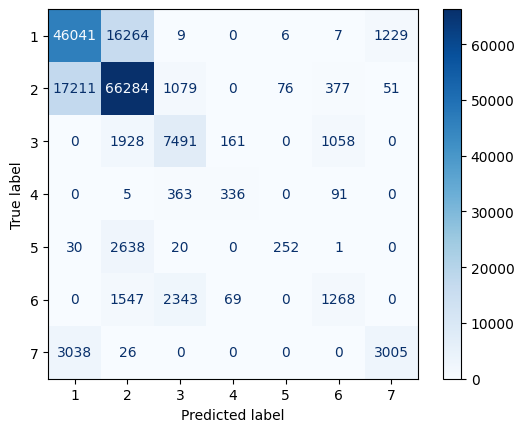

In [10]:
# Avaliando o desempenho da rede
y_pred = mlp.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
prec = precision_score(y_test, y_pred, average="weighted")
rec = recall_score(y_test, y_pred, average="weighted")

print(f"Acurácia: {acc}")
print(f"F-Score: {f1}")
print(f"Precisão: {prec}")
print(f"Revocação: {rec}")

ConfusionMatrixDisplay.from_estimator(mlp, X_test_scaled, y_test, cmap='Blues')
plt.show()

In [7]:
# Repetindo o treinamento (10 vezes com novas partições)

# Média e Desvio Padrão do Conjunto de Treino
accs_train, f1s_train = [], []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=i, shuffle=True
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    mlp = MLPClassifier((10,), activation="relu", solver="adam", max_iter=300)
    mlp.fit(X_train_scaled, y_train)

    y_train_pred = mlp.predict(X_train_scaled)
    accs_train.append(accuracy_score(y_train, y_train_pred))
    f1s_train.append(f1_score(y_train, y_train_pred, average="weighted"))

In [9]:
print(f"Treino - Acurácia Média: {np.mean(accs_train)} +- {np.std(accs_train)}")
print(f"Treino - F1-Score Médio: {np.mean(f1s_train)} +- {np.std(f1s_train)}")

Treino - Acurácia Média: 0.7181220925086303 +- 0.0021677216599566597
Treino - F1-Score Médio: 0.7090807644906371 +- 0.0025649973878620453


In [ ]:
# Repetindo o treinamento (10 vezes usando o otimizador SGD)
accs_train_sgd, f1s_train_sgd = [], []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=i, shuffle=True
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    mlp = MLPClassifier((10,), activation="relu", solver="sgd", max_iter=300)
    mlp.fit(X_train_scaled, y_train)
    y_train_pred = mlp.predict(X_train_scaled)

    accs_train_sgd.append(accuracy_score(y_train, y_train_pred))
    f1s_train_sgd.append(f1_score(y_train, y_train_pred, average="weighted"))

Treinamento 1/10
Treinamento 2/10
Treinamento 3/10
Treinamento 4/10
Treinamento 5/10
Treinamento 6/10
Treinamento 7/10
Treinamento 8/10
Treinamento 9/10
Treinamento 10/10


In [ ]:
print(f"Treino - Acurácia Média: {np.mean(accs_train_sgd)} +- {np.std(accs_train_sgd)}")
print(f"Treino - F1-Score Médio: {np.mean(f1s_train_sgd)} +- {np.std(f1s_train_sgd)}")

Treino - Acurácia Média: 0.7150097858906144 +- 0.0025334282747923433
Treino - F1-Score Médio: 0.7040238343828074 +- 0.0031664468423970925


### Análise dos Resultados
Os testes realizados com 10 repetições mostraram resultados semelhantes entre os otimizadores _Adam_ e _SGD_.
O desempenho do modelo ficou em torno de 0.7 tanto na acurácia média quanto no _F1-score_ médio, sugerindo comportamento estável e consistente no problema de classificação multiclasse. A rede ainda apresenta espaço para aprimoramentos, por meio de ajustes nos hiperparâmetros, aumento no número de neurônios ou balanceamento dos dados, o que pode resultar em métricas mais satisfatórias nas proximas experimentações.

## Discussão

Nos passos anteriores, você avaliou o desempenho de uma única rede neural que contém os seguintes parâmetros: uma única camada oculta com 10 neurônios e função de ativação ReLU. O otimizador utilizado, quer seja SGD ou ADAM, trata-se do algoritmo para aproximar o gradiente do erro. Neste sentido, a escolha do otimizador é um hiperparâmetro, pois diz respeito a como a rede neural definida previamente atuará "em tempo de execução"  durante o processo de treinamento. Também são hiperparâmetros a quantidade de épocas, a taxa de aprendizado inicial, dentre outros.

Cabe alientar também que você efetuou o treinamento desta rede por 10 vezes e apresentou os resultados em termos de média +- desvio padrão. Lembre-se que em uma rede neural há a inicialização aleatória de pesos e, em consequência, o desempenho delas está sujeito à uma flutuação estocástica. A execução destas múltiplas vezes faz com que eliminemos algum viés introduzido por uma boa ou má "sorte" na escolha de pesos no caso de uma única execução.

Você também aprendeu uma estratégia para escalonar os atributos para uma melhor convergência da rede. Utilize-a em todos os treinamentos e testes propostos a seguir.

## Propondo Novas Arquiteturas

Variando  os parâmetros (uma ou duas camadas ocultas, com diferente números de neurônios em cada uma delas e a função de ativação) e o hiperparâmetros solver (Adam ou SGD) e o número de épocas (100,150 e 200), atenda ao que se pede:

1. Proponha 10 arquiteturas distintas de RNAs para o problema em questão, à sua escolha
2. Avalie cada uma das arquiteturas perante todos os hiperparâmetros, repetindo cada treinamento/avaliação por 10 vezes
3. Como resultado da avaliação, apresente:  
    3.1 Top-3 melhores redes no tocante à F-Score e Acurácia  
    3.2 Repetição em que houve o melhor desempenho de cada uma dessas redes: ilustre tp, tf, fp e fn  

In [10]:
# Variáveis para os testes
n_repeats = 10
test_size = 0.3

# Controle sobre a qtd de repetições sem melhora no modelo
max_no_improve = 3

architectures = [
    ((10, ), "tanh", "adam", 150),
    ((20, ), "logistic", "adam", 200),
    ((50,), "identity", "sgd", 100),
    ((100,), "tanh", "adam", 100),
    ((10, 10), "relu", "sgd", 150),
    ((30, 30), "relu", "sgd", 150),
    ((150, 50), "logistic", "sgd", 200),
    ((40, 20, 10), "relu", "adam", 100),
    ((50, 30, 20), "tanh", "sgd", 150),
    ((60, 40, 30), "relu", "adam", 200)
]

# Resultados por arquitetura
summary_rows = []


In [ ]:
for arch_idx, (arch, activation, solver, epochs) in enumerate(architectures):
  print(f"\n=== Arquitetura {arch_idx+1}/{len(architectures)}: {arch}, act='{activation}', solver='{solver}', epochs='{epochs}' ===")

  # resultados desta arquitetura
  accs = []
  f1s = []

  best_acc = 0
  best_f1 = 0
  no_improve = 0

  # resultados por repetição da arquitetura
  per_repeat_details = []

  for i in range(n_repeats):
    print(f"Treinamento {i+1}/10")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=i, shuffle=True
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    model = MLPClassifier(
        hidden_layer_sizes=arch,
        activation=activation,
        solver=solver,
        max_iter=epochs,
        early_stopping=True
    )
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    accs.append(acc)
    f1s.append(f1)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

    print(f"acc={acc:.4f} | f1={f1:.4f}")

    if acc > best_acc or f1 > best_f1:
      best_acc = max(best_acc, acc)
      best_f1 = max(best_f1, f1)
      no_improve = 0
    else:
      no_improve += 1

    if no_improve >= max_no_improve:
      print(f"Treinamento encerrado - sem melhora em {max_no_improve} repetições")
      break

    per_repeat_details.append({
    'training': i,
    'model': model,
    'accuracy': acc,
    'f1_score': f1,
    'confusion_matrix': cm
    })

  summary_rows.append({
    'architecture': str(arch),
    'activation': activation,
    'solver': solver,
    'epochs': epochs,
    'acc_mean': np.mean(accs),
    'acc_std': np.std(accs),
    'f1_mean': np.mean(f1s),
    'f1_std': np.std(f1s),
    'details': per_repeat_details
  })


=== Arquitetura 1/10: (10,), act='tanh', solver='adam', epochs='150' ===
Treinamento 1/10
acc=0.7185 | f1=0.7078
Treinamento 2/10
acc=0.7165 | f1=0.7056
Treinamento 3/10
acc=0.7208 | f1=0.7112
Treinamento 4/10
acc=0.7176 | f1=0.7067
Treinamento 5/10
acc=0.7189 | f1=0.7107
Treinamento 6/10
acc=0.7129 | f1=0.7022
Treinamento encerrado - sem melhora em 3 repetições

=== Arquitetura 2/10: (20,), act='logistic', solver='adam', epochs='200' ===
Treinamento 1/10
acc=0.7397 | f1=0.7313
Treinamento 2/10
acc=0.7374 | f1=0.7298
Treinamento 3/10
acc=0.7401 | f1=0.7299
Treinamento 4/10
acc=0.7381 | f1=0.7305
Treinamento 5/10
acc=0.7390 | f1=0.7319
Treinamento 6/10
acc=0.7262 | f1=0.7175
Treinamento 7/10
acc=0.7428 | f1=0.7345
Treinamento 8/10
acc=0.7368 | f1=0.7277
Treinamento 9/10
acc=0.7385 | f1=0.7303
Treinamento 10/10
acc=0.7372 | f1=0.7302
Treinamento encerrado - sem melhora em 3 repetições

=== Arquitetura 3/10: (50,), act='identity', solver='sgd', epochs='100' ===
Treinamento 1/10
acc=0.697

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


acc=0.8006 | f1=0.7984
Treinamento 2/10


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


acc=0.7999 | f1=0.7976
Treinamento 3/10
acc=0.7978 | f1=0.7950
Treinamento 4/10


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


acc=0.7965 | f1=0.7933
Treinamento encerrado - sem melhora em 3 repetições

=== Arquitetura 5/10: (10, 10), act='relu', solver='sgd', epochs='150' ===
Treinamento 1/10
acc=0.7190 | f1=0.7056
Treinamento 2/10
acc=0.7172 | f1=0.7047
Treinamento 3/10
acc=0.7289 | f1=0.7194
Treinamento 4/10
acc=0.7283 | f1=0.7176
Treinamento 5/10
acc=0.7313 | f1=0.7216
Treinamento 6/10
acc=0.7239 | f1=0.7163
Treinamento 7/10
acc=0.7222 | f1=0.7102
Treinamento 8/10
acc=0.7274 | f1=0.7161
Treinamento encerrado - sem melhora em 3 repetições

=== Arquitetura 6/10: (30, 30), act='relu', solver='sgd', epochs='150' ===
Treinamento 1/10


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


acc=0.7813 | f1=0.7769
Treinamento 2/10
acc=0.7666 | f1=0.7594
Treinamento 3/10
acc=0.7726 | f1=0.7661
Treinamento 4/10


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


acc=0.7805 | f1=0.7759
Treinamento encerrado - sem melhora em 3 repetições

=== Arquitetura 7/10: (150, 50), act='logistic', solver='sgd', epochs='200' ===
Treinamento 1/10
acc=0.6973 | f1=0.6781
Treinamento 2/10
acc=0.6977 | f1=0.6773
Treinamento 3/10
acc=0.6970 | f1=0.6772
Treinamento 4/10
acc=0.6947 | f1=0.6688
Treinamento 5/10
acc=0.6941 | f1=0.6688
Treinamento encerrado - sem melhora em 3 repetições

=== Arquitetura 8/10: (40, 20, 10), act='relu', solver='adam', epochs='100' ===
Treinamento 1/10
acc=0.7798 | f1=0.7767
Treinamento 2/10
acc=0.7921 | f1=0.7876
Treinamento 3/10
acc=0.7987 | f1=0.7955
Treinamento 4/10


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


acc=0.7952 | f1=0.7930
Treinamento 5/10


In [ ]:
summary_df = pd.DataFrame(summary_rows)

summary_df_sorted_f1_acc = summary_df.sort_values(by=["f1_mean", "acc_mean"], ascending=False).reset_index(drop=True)

print("Top-3 por F1-score e Acurácia:")
display(summary_df_sorted_f1_acc.head(3)[['architecture', 'f1_mean', 'f1_std', 'acc_mean', 'acc_std']])

Top-3 por F1-score e Acurácia:


,architecture,f1_mean,f1_std,acc_mean,acc_std
0,"(60, 40, 30)",0.846116,0.003483,0.847098,0.003939
1,"(50, 30, 20)",0.810193,0.000796,0.813484,0.000582
2,"(100,)",0.794338,0.001131,0.797056,0.001486


In [ ]:
# Função que retorna os valores da matriz de confusão
def per_class_confusion_stats(cm):
  tp = np.diag(cm)
  fp = np.sum(cm, axis=0) - tp
  fn = np.sum(cm, axis=1) - tp
  tn = np.sum(cm) - (tp + fp + fn)
  return tp, fp, fn, tn


Arquitetura (Top1): (60, 40, 30) - melhor repetição: 1
Acurácia: 0.8510 | F1: 0.8496


<Figure size 600x500 with 0 Axes>

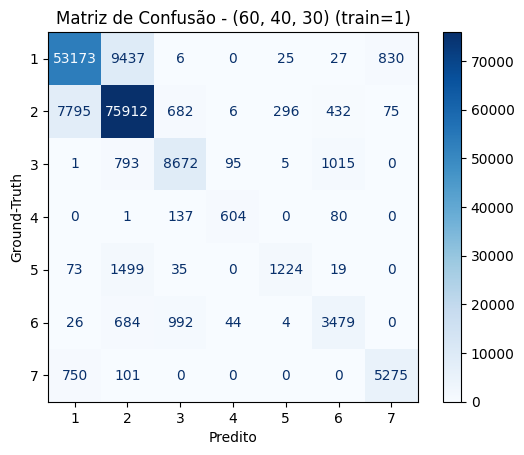

,Classe,TP,FP,FN,TN
0,1,53173,8645,10325,102161
1,2,75912,12515,9286,76591
2,3,8672,1852,1909,161871
3,4,604,145,218,173337
4,5,1224,330,1626,171124
5,6,3479,1573,1750,167502
6,7,5275,905,851,167273



Arquitetura (Top2): (50, 30, 20) - melhor repetição: 1
Acurácia: 0.8141 | F1: 0.8110


<Figure size 600x500 with 0 Axes>

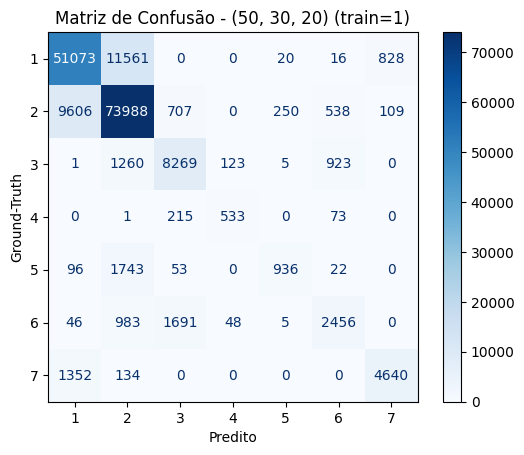

,Classe,TP,FP,FN,TN
0,1,51073,11101,12425,99705
1,2,73988,15682,11210,73424
2,3,8269,2666,2312,161057
3,4,533,171,289,173311
4,5,936,280,1914,171174
5,6,2456,1572,2773,167503
6,7,4640,937,1486,167241



Arquitetura (Top3): (100,) - melhor repetição: 1
Acurácia: 0.7985 | F1: 0.7955


<Figure size 600x500 with 0 Axes>

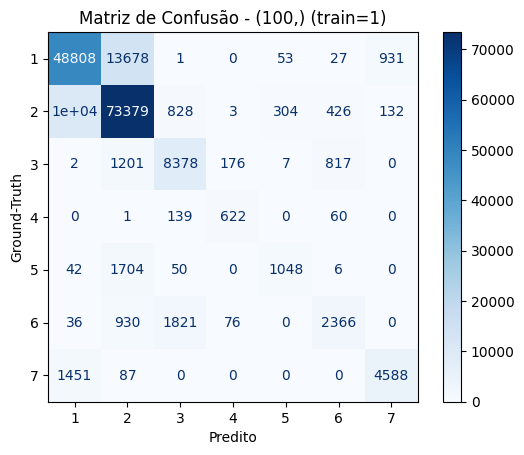

,Classe,TP,FP,FN,TN
0,1,48808,11657,14690,99149
1,2,73379,17601,11819,71505
2,3,8378,2839,2203,160884
3,4,622,255,200,173227
4,5,1048,364,1802,171090
5,6,2366,1336,2863,167739
6,7,4588,1063,1538,167115


In [ ]:
top3 = summary_df_sorted_f1_acc.head(3)

for idx, row in top3.iterrows():
  arch = row['architecture']
  details = row['details']
  best = max(details, key=lambda x: x['f1_score'])
  cm = best['confusion_matrix']
  train = best['training']
  print(f"\nArquitetura (Top{idx+1}): {arch} - melhor repetição: {train+1}")
  print(f"Acurácia: {best['accuracy']:.4f} | F1: {best['f1_score']:.4f}")

  plt.figure(figsize=(6, 5))
  ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(cmap='Blues')
  plt.title(f"Matriz de Confusão - {arch} (train={train+1})")
  plt.xlabel("Predito")
  plt.ylabel("Ground-Truth")
  plt.show()

  tp, fp, fn, tn = per_class_confusion_stats(cm)
  classes = np.unique(y)
  df_stats = pd.DataFrame({
    'Classe': classes,
    'TP': tp,
    'FP': fp,
    'FN': fn,
    'TN': tn
  })
  display(df_stats)


## Estimando o número de neurônios

Um dos problemas de pesquisa com redes neurais artificiais consiste na determinação do número de neurônios em sua arquitetura. Embora não seja possível definir a priori qual rede neural é adequada para um problema, pois isto só é possível mediante uma busca exaustiva, há regras na literatura que sugerem o número de neurônios escondidos, tal como a regra da Pirâmide Geométrica, dada a seguir:

$$N_h = \alpha \cdot \sqrt{N_i \cdot N_o},$$

em que $N_h$ é o número de neurônios ocultos (a serem distribuídos em uma ou duas camadas ocultas), $N_i$ é o número de neurônios na camada de entrada e $N_o$ é o número de neurônios na camada de saída.

1. Consulte a documentação da classe MLPClassifier (disponível em https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) e obtenha os valores de $N_i$ e $N_o$.
2. Teste os valores de $\alpha$ como sendo iguais a $0.5$, $2$ e $3$.
3. Proponha pelo menos 30 redes neurais segundo a regra da pirâmide geométrica e teste-as nos mesmos termos estabelecidos anterioremente  (solver, épocas, etc.)  
    3.1 Apresente as top-3 melhores redes no tocante à F-Score e Acurácia  

In [ ]:
Ni = mlp.n_features_in_
No = mlp.n_outputs_

alphas = [0.5, 2, 3]

print(f"Nº Neurônios Entrada: {Ni}")
print(f"Nº Neurônios Saída: {No}")

activations = ["relu", "logistic", "tanh"]
solvers = ["adam", "sgd"]
max_epochs = [100, 150, 200]

architectures_nh = []

for alpha in alphas:
  Nh = int(alpha * np.sqrt(Ni*No))
  for act in activations:
    for solver in solvers:
      for epochs in max_epochs:
        if epochs == 100:
          layers = (Nh, )
        else:
          layers = (Nh, Nh // 2)
        architectures_nh.append((layers, act, solver, epochs))
print(f"Total de arquiteturas geradas: {len(architectures_nh)}")
architectures_test = random.sample(architectures_nh, 10)
print(f"Total de arquiteturas p/ testes: {len(architectures_test)}")
architectures_test

Nº Neurônios Entrada: 10
Nº Neurônios Saída: 7
Total de arquiteturas geradas: 54
Total de arquiteturas p teste: 10


[((16,), 'tanh', 'sgd', 100),
 ((4,), 'tanh', 'adam', 100),
 ((4, 2), 'logistic', 'adam', 150),
 ((25, 12), 'logistic', 'adam', 150),
 ((4, 2), 'relu', 'sgd', 200),
 ((16, 8), 'relu', 'sgd', 200),
 ((16, 8), 'logistic', 'sgd', 150),
 ((4,), 'tanh', 'sgd', 100),
 ((25, 12), 'relu', 'sgd', 150),
 ((16, 8), 'logistic', 'adam', 200)]

In [ ]:
# Resultados por arquitetura
summary_rows_nh = []

# Variáveis p/ controle nos testes
max_no_improve = 3
n_repeats = 3
test_size = 0.3

for arch_idx, (arch, activation, solver, epochs) in enumerate(architectures_test):
  print(f"\n=== Arquitetura {arch_idx+1}/{len(architectures_test)}: {arch}, act='{activation}', solver='{solver}', epochs='{epochs}' ===")
  accs = []
  f1s = []

  best_acc = 0
  best_f1 = 0
  no_improve = 0

  for i in range(n_repeats):
    print(f"Treinamento {i+1}/{n_repeats}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=i, shuffle=True
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    model = MLPClassifier(
        hidden_layer_sizes=arch,
        activation=activation,
        solver=solver,
        max_iter=epochs,
        early_stopping=True
    )
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    accs.append(acc)
    f1s.append(f1)

    print(f"acc={acc:.4f} | f1={f1:.4f}")

    # Verifica se houve melhora na acurácia ou F1-Score
    if acc > best_acc or f1 > best_f1:
        best_acc = max(best_acc, acc)
        best_f1 = max(best_f1, f1)
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= max_no_improve:
        print(f"Treinamento encerrado - sem melhora em {max_no_improve} repetições")
        break

  summary_rows_nh.append({
    'architecture': str(arch),
    'activation': activation,
    'solver': solver,
    'epochs': epochs,
    'acc_mean': np.mean(accs),
    'acc_std': np.std(accs),
    'f1_mean': np.mean(f1s),
    'f1_std': np.std(f1s),
  })


Treinamento 1/3


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Treinamento 2/3


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Treinamento 3/3


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Treinamento 1/3
Treinamento 2/3
Treinamento 3/3
Treinamento 1/3
Treinamento 2/3
Treinamento 3/3
Treinamento 1/3
Treinamento 2/3
Treinamento 3/3
Treinamento 1/3
Treinamento 2/3
Treinamento 3/3
Treinamento 1/3
Treinamento 2/3
Treinamento 3/3
Treinamento 1/3
Treinamento 2/3
Treinamento 3/3
Treinamento 1/3
Treinamento 2/3
Treinamento 3/3
Treinamento 1/3


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Treinamento 2/3
Treinamento 3/3
Treinamento 1/3
Treinamento 2/3
Treinamento 3/3


In [ ]:
summary_df_nh = pd.DataFrame(summary_rows_nh)

summary_df_nh_top = summary_df_nh.sort_values(by=["f1_mean", "acc_mean"], ascending=False).reset_index(drop=True)

print("Top-3 por F1-score e Acuracia:")
display(summary_df_nh_top.head(3)[['architecture', 'f1_mean', 'f1_std', 'acc_mean', 'acc_std']])

,architecture,activation,solver,epochs,acc_mean,acc_std,f1_mean,f1_std
0,"(25, 12)",logistic,adam,150,0.757177,0.004308,0.750455,0.005494
1,"(25, 12)",relu,sgd,150,0.752216,0.005060,0.745332,0.005903
2,"(16, 8)",logistic,adam,200,0.739683,0.002743,0.730727,0.003517
3,"(16, 8)",relu,sgd,200,0.733479,0.003579,0.722848,0.005669
4,"(16,)",tanh,sgd,100,0.724747,0.002884,0.713736,0.002098
5,"(16, 8)",logistic,sgd,150,0.706863,0.006137,0.685527,0.012839
6,"(4,)",tanh,adam,100,0.699443,0.001660,0.682508,0.003853
7,"(4, 2)",relu,sgd,200,0.700493,0.001682,0.678539,0.003245
8,"(4,)",tanh,sgd,100,0.696928,0.001881,0.671377,0.009457
9,"(4, 2)",logistic,adam,150,0.700431,0.000544,0.669051,0.000201


Top-3 por F1-score e Acuracia:


,architecture,f1_mean,f1_std,acc_mean,acc_std
0,"(25, 12)",0.750455,0.005494,0.757177,0.004308
1,"(25, 12)",0.745332,0.005903,0.752216,0.005060
2,"(16, 8)",0.730727,0.003517,0.739683,0.002743


## Testando as Redes Neurais com Atributos Categóricos

1. Considere as 6 redes neurais obtidas nos dois top-3 anteriores (arquiteturas próprias e regra da pirâmide geométrica)
2. Com todos os atributos preditores da base de dados original, incluindo os categóricos, treine e teste estas mesmas redes por 100 repetições  
    2.1 Considere o melhor otimizador para cada uma delas  
    2.2 Faça uso de 200 épocas para treinamento  
    2.2 Apresente os resultados de acurácia e F-Score em termos da média +- dp para cada arquitetura
3. Apresente o gráfico boxplot para o F-Score das 6 arquiteturas perante 10 repetições de cada (aferir flutuação estocástica)

In [1]:
# Teste com as 6 redes neurais dos top-3 anteriores
architectures_final = [
    ((60, 40, 30), 'relu', 'adam'),
    ((50, 30, 20), 'tanh', 'sgd'),
    ((100), 'tanh', 'adam'),
    ((25, 12), 'logistic', 'adam'),
    ((25, 12), 'relu', 'sgd'),
    ((16, 8), 'logistic', 'adam')
]

In [2]:
# Variáveis para os testes
n_repeats = 100
test_size = 0.3
max_iter = 200
n_iter_no_change = 10
save_every = 10       # salva resultados a cada N repetições
out_csv = "results_architectures_all_attributes.csv"
out_pickle = "results_architectures_all_attributes.pkl"

In [7]:
# Atributos preditores e variável-alvo
X_final = df.drop(columns=['Cover_Type'])
y_final = df['Cover_Type']

# Identifica colunas numéricas para escalonamento (não escalar as já binárias categóricas)
numeric_cols = X_final.select_dtypes(include=[np.number]).columns.tolist()

# Identifica colunas categóricas one-hot por padrão (se forem estritamente 0/1)
binary_cols = [c for c in numeric_cols if set(X_final[c].unique()) <= {0,1}]

# Considera numéricas reais como set difference
true_numeric_cols = [c for c in numeric_cols if c not in binary_cols]

In [8]:
# Criar estrutura para salvar resultados
all_results = []  # lista de dicts: arquitetura, repeat_index, acc, f1, time

# Se existir arquivo salvo anteriormente, carregar para retomar
if os.path.exists(out_pickle):
    try:
        with open(out_pickle, "rb") as f:
            checkpoint = pickle.load(f)
        all_results = checkpoint.get("all_results", [])
        start_from = checkpoint.get("last_repeat_index", 0)
        print(f"Checkpoint encontrado. Retomando a partir da repetição {start_from}.")
    except Exception as e:
        print("Não foi possível carregar checkpoint:", e)
        start_from = 0
else:
    start_from = 0

# ---------- Loop pelas arquiteturas ----------
start_time_total = time.time()
for arch_idx, (arch, activation, solver) in enumerate(architectures_final):
    print(f"\n=== Arquitetura {arch_idx+1}/{len(architectures_final)}: {arch}, act='{activation}', solver='{solver}' ===")
    # resultados desta arquitetura
    accs = []
    f1s = []
    # Continuar de onde parou apenas por segurança geral (apenas se houver checkpoint global)
    for rep in range(start_from, n_repeats):

        t0 = time.time()
        # Nova partição
        X_train, X_test, y_train, y_test = train_test_split(
            X_final, y_final, test_size=test_size, random_state=rep, shuffle=True
        )

        # Padronizar apenas colunas numéricas verdadeiras
        scaler = StandardScaler()
        X_train_num = scaler.fit_transform(X_train[true_numeric_cols])
        X_test_num = scaler.transform(X_test[true_numeric_cols])
        # Recombina com as colunas binárias (mantém ordem de colunas)
        X_train_proc = np.hstack([X_train_num, X_train[binary_cols].values]) if binary_cols else X_train_num
        X_test_proc = np.hstack([X_test_num, X_test[binary_cols].values]) if binary_cols else X_test_num

        # Treinamento
        mlp = MLPClassifier(
            hidden_layer_sizes=arch,
            activation=activation,
            solver=solver,
            max_iter=max_iter,
            early_stopping=True,
            n_iter_no_change=n_iter_no_change,
            random_state=rep,
            verbose=False
        )

        try:
            mlp.fit(X_train_proc, y_train)
        except Exception as e:
            print(f"Erro no treino (arquitetura {arch}, rep {rep}): {e}")
            # salva e segue
            with open(out_pickle, "wb") as f:
                pickle.dump({"all_results": all_results, "last_repeat_index": rep}, f)
            raise

        y_pred = mlp.predict(X_test_proc)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")

        accs.append(acc)
        f1s.append(f1)

        all_results.append({
            "architecture": arch,
            "activation": activation,
            "solver": solver,
            "repeat": rep,
            "acc": acc,
            "f1": f1
        })

        t1 = time.time()
        if (rep + 1) % save_every == 0 or rep == n_repeats - 1:
            # salva CSV e pickle incremental
            df_save = pd.DataFrame(all_results)
            df_save.to_csv(out_csv, index=False)
            with open(out_pickle, "wb") as f:
                pickle.dump({"all_results": all_results, "last_repeat_index": rep+1}, f)
            print(f"[{arch}] Rep {rep+1}/{n_repeats} — acc={acc:.4f} f1={f1:.4f} (iter time {t1-t0:.1f}s). Checkpoint salvo.")

    # Fim repetições desta arquitetura
    # Calcular estatísticas agregadas
    acc_mean = np.mean(accs)
    acc_std = np.std(accs)
    f1_mean = np.mean(f1s)
    f1_std = np.std(f1s)
    print(f"Resumo {arch}: Acurácia média={acc_mean:.4f} ± {acc_std:.4f}, F1 média={f1_mean:.4f} ± {f1_std:.4f}")

# fim loop arquiteturas
end_time_total = time.time()
print(f"\nTempo total (aprox): {(end_time_total - start_time_total)/60:.1f} minutos")
# salva resultados finais (certifica-se)
pd.DataFrame(all_results).to_csv(out_csv, index=False)
with open(out_pickle, "wb") as f:
    pickle.dump({"all_results": all_results, "last_repeat_index": n_repeats}, f)


Checkpoint encontrado. Retomando a partir da repetição 100.

=== Arquitetura 1/6: (60, 40, 30), act='relu', solver='adam' ===
Resumo (60, 40, 30): Acurácia média=nan ± nan, F1 média=nan ± nan

=== Arquitetura 2/6: (50, 30, 20), act='tanh', solver='sgd' ===
Resumo (50, 30, 20): Acurácia média=nan ± nan, F1 média=nan ± nan

=== Arquitetura 3/6: 100, act='tanh', solver='adam' ===
Resumo 100: Acurácia média=nan ± nan, F1 média=nan ± nan

=== Arquitetura 4/6: (25, 12), act='logistic', solver='adam' ===
Resumo (25, 12): Acurácia média=nan ± nan, F1 média=nan ± nan

=== Arquitetura 5/6: (25, 12), act='relu', solver='sgd' ===
Resumo (25, 12): Acurácia média=nan ± nan, F1 média=nan ± nan

=== Arquitetura 6/6: (16, 8), act='logistic', solver='adam' ===
Resumo (16, 8): Acurácia média=nan ± nan, F1 média=nan ± nan

Tempo total (aprox): 0.0 minutos


C:\Users\Lenovo\anaconda3\envs\rna-testes\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Lenovo\anaconda3\envs\rna-testes\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Lenovo\anaconda3\envs\rna-testes\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\envs\rna-testes\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Lenovo\anaconda3\envs\rna-testes\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
# ---------- Apresentar resultados agregados ----------
df_res = pd.DataFrame(all_results)
df_res["architecture"] = df_res["architecture"].apply(str)
summary = df_res.groupby(["architecture", "activation", "solver"]).agg(
    acc_mean=("acc", "mean"),
    acc_std=("acc", "std"),
    f1_mean=("f1", "mean"),
    f1_std=("f1", "std"),
    n_reps=("repeat", "count")
).reset_index()
# Mostrar tabela (arredonda para facilitar leitura)
summary_display = summary.copy()
summary_display[["acc_mean","acc_std","f1_mean","f1_std"]] = summary_display[["acc_mean","acc_std","f1_mean","f1_std"]].round(4)
display(summary_display.sort_values(by="f1_mean", ascending=False).reset_index(drop=True))

,architecture,activation,solver,acc_mean,acc_std,f1_mean,f1_std,n_reps
0,"(60, 40, 30)",relu,adam,0.8950,0.0037,0.8944,0.0035,11
1,100,tanh,adam,0.8817,0.0057,0.8809,0.0059,4
2,"(50, 30, 20)",tanh,sgd,0.8775,0.0040,0.8764,0.0041,6
3,"(25, 12)",logistic,adam,0.8302,0.0033,0.8278,0.0033,4
4,"(25, 12)",relu,sgd,0.8048,0.0040,0.7999,0.0043,8
5,"(16, 8)",logistic,adam,0.7959,0.0018,0.7914,0.0019,4


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19500\788968756.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=labels, showmeans=True)


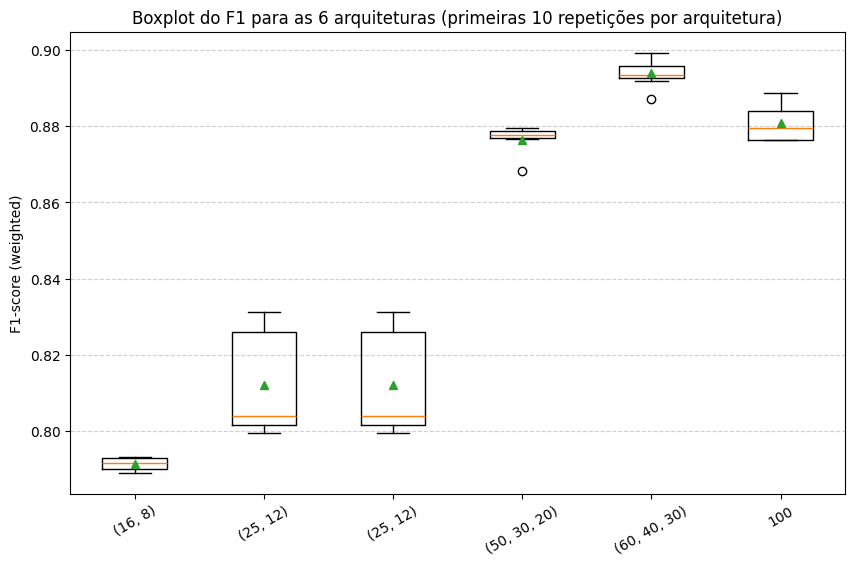

In [23]:
# ---------- Boxplot do F1 para as 6 arquiteturas com as primeiras 10 repetições (ou menos se n_repeats < 10) ----------
use_n_for_boxplot = min(10, n_repeats)
boxplot_data = []
labels = []
for arch in summary_display["architecture"]:
    subset = df_res[df_res["architecture"] == arch].sort_values("repeat").head(use_n_for_boxplot)
    boxplot_data.append(subset["f1"].values)
    labels.append(arch)

plt.figure(figsize=(10,6))
plt.boxplot(boxplot_data, labels=labels, showmeans=True)
plt.ylabel("F1-score (weighted)")
plt.title(f"Boxplot do F1 para as 6 arquiteturas (primeiras {use_n_for_boxplot} repetições por arquitetura)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Considerações Parciais

1. É possível identificar uma rede com desempenho superior às demais?
2. Qual estratégia mostrou-se mais producente para a obtenção de boas arquiteturas (Estratégia Própria ou Pirâmide Geométrica)? Por quê?
3. Considerar os atributos categóricos trouxe melhorias? Justifique.
4. Um número maior de épocas trouxe melhorias?
5. Qual a maior dificuldade de resolução do problema proposto perante as RNAs?

Os resultados obtidos indicam que as arquiteturas próprias apresentaram desempenho superior às redes definidas pela regra da Pirâmide Geométrica, tanto em acurácia quanto em _F1-score_. O melhor modelo, com arquitetura (60, 40, 30) e função de ativação _ReLU_, alcançou as médias de acurácia e _F1-score_média de em torno de 0.85.

Entre as arquiteturas propostas manualmente, observou-se uma vantagem clara dos modelos mais profundos e com o otimizador _Adam_, sugerindo melhor capacidade de aprendizado e generalização dos dados. Já as arquiteturas da pirâmide apresentaram desempenho estável, porém limitado, com métricas variando entre 0.73 e 0.75, o que indica que, apesar da simplicidade e da base teórica da regra, ela pode gerar redes subdimensionadas para o problema em questão.

Ao incorporar os atributos categóricos e aumentar o número de épocas para 200, houve uma melhora relativa nas métricas. O modelo (60, 40, 30), agora treinado com todos os atributos, atingiu acurácia e _F1-score_ médios em cerca de 0.89, mostrando que a presença de variáveis categóricas codificadas ampliou a capacidade do modelo de distinguir entre as diferentes classes de cobertura florestal.

Quanto a execução dos experimentos, a principal dificuldade observada está relacionada ao tempo de processamento elevado, que limita a experimentação para um número maior de arquiteturas e quantidade de repetições, em que foi preciso adaptar tais parâmetros por questões de custo computacional. Além disso, a natureza desbalanceada e multiclasse do conjunto de dados continua sendo um desafio, exigindo ajustes cuidadosos para evitar vieses nos modelos.